In [19]:
import ROOT
from sys import exit
import numpy as np
from numpy.testing import assert_array_equal
from nose.tools import (raises, assert_raises, assert_true,
                        assert_equal, assert_almost_equal)
import root_numpy as rnp
import pandas as pd
from pandas.plotting import scatter_matrix
ROOT.ROOT.EnableImplicitMT()

from sklearn import preprocessing

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#look at data loaded
import matplotlib.pyplot as plt
import plotly.express as px

#read in key parameters from root file
#data = rnp.root2array("../data_02/mlTree.root","mltree",branches=['x','e1','e2','e3','e12','e13',
#                                                                   'e23','e123','recoilID'])

data_in = rnp.root2array("../data/pyTreeAverageSkinK_train.root","pytree",
                         branches=['e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'])
assert_equal(data_in.dtype.names, ('e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'))
print(data_in.dtype)
num_data_columns=14.0
#convert to pandas
df = pd.DataFrame(data=data_in)
print(df)
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)
res_df = pd.DataFrame(x_scaled)
df_g1293 = df[(df['ge'] > 1285) & (df['ge'] < 1298)]
print(df_g1293.size/num_data_columns)
#data to torch tensor
X = torch.from_numpy(res_df.values).float().to(torch.device('cpu'))
#print(X)

[('e0', '<f4'), ('e1', '<f4'), ('e2', '<f4'), ('e3', '<f4'), ('e4', '<f4'), ('e5', '<f4'), ('e6', '<f4'), ('x', '<f4'), ('m', '<f4'), ('dt', '<f4'), ('gmult', '<i4'), ('ge', '<f4'), ('gid', '<f4'), ('glabel', '<f4')]
                e0           e1           e2           e3           e4  \
0      2161.321289  1341.359253  1948.864014  3502.680664  4110.185547   
1      2077.941895  1270.559204  1880.864014  3348.500977  3958.805908   
2      2086.162354  1304.159180  1764.864014  3390.321533  3851.026367   
3      2086.162354  1304.159180  1764.864014  3390.321533  3851.026367   
4      1845.418579  1110.959229  1367.864014  2956.377930  3213.282715   
...            ...          ...          ...          ...          ...   
33251  1654.471680   921.133484  1175.869019  2575.605225  2830.340820   
33252  1625.559692   930.443481  1058.869019  2556.003174  2684.428711   
33253  1747.879639   925.123474  1218.869019  2673.003174  2966.748535   
33254  1599.983643   875.913452  1051.86901

In [20]:
#Model D with AverageFatD_train data (mar31 9pm)
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(11, 40)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(40, 20)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(20, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()

In [21]:
#print(net.parameters)
#print(net.state_dict())
save_path="./model_saves/model_K.pt"
net = torch.load(save_path)
net.eval()

/usr/local/lib/python3.7/site-packages/torch/serialization.py:559: UserWarning:

Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.



Net(
  (fc1): Linear(in_features=11, out_features=40, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=20, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [22]:
with torch.no_grad():
    result = net(X[0:6000000,0:11])
    #result = torch.round(result)
print(torch.max(result))
print(torch.min(result))
torch.histc(result)
#print(result.data)
print(len(result))
df_F = pd.DataFrame(data=result.numpy())
#print(df_F)
df_F.columns = ["A"]
result_df = pd.concat([df, df_F], axis=1)
print(result_df)
#fig = px.histogram(df_F,x="A",nbins=100)
#fig.update_xaxes(range=[0.0,1.0])
#fig.show()

tensor(0.8674)
tensor(0.0080)
33256
                e0           e1           e2           e3           e4  \
0      2161.321289  1341.359253  1948.864014  3502.680664  4110.185547   
1      2077.941895  1270.559204  1880.864014  3348.500977  3958.805908   
2      2086.162354  1304.159180  1764.864014  3390.321533  3851.026367   
3      2086.162354  1304.159180  1764.864014  3390.321533  3851.026367   
4      1845.418579  1110.959229  1367.864014  2956.377930  3213.282715   
...            ...          ...          ...          ...          ...   
33251  1654.471680   921.133484  1175.869019  2575.605225  2830.340820   
33252  1625.559692   930.443481  1058.869019  2556.003174  2684.428711   
33253  1747.879639   925.123474  1218.869019  2673.003174  2966.748535   
33254  1599.983643   875.913452  1051.869019  2475.896973  2651.852539   
33255  1246.367676   574.003479   684.869019  1820.371094  1931.236694   

                e5           e6           x            m     dt  gmult  \
0

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     22741
         1.0       0.74      0.73      0.74     10515

    accuracy                           0.84     33256
   macro avg       0.81      0.81      0.81     33256
weighted avg       0.83      0.84      0.83     33256

[[20068  2673]
 [ 2807  7708]]
[[0.88245899 0.11754101]
 [0.26695197 0.73304803]]


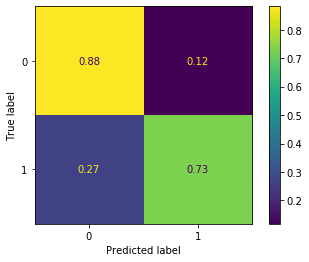

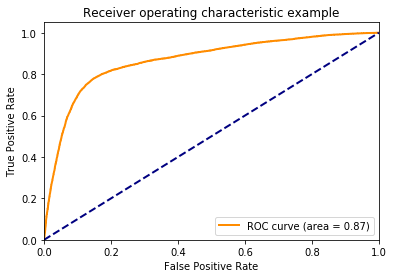

In [23]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
#y = true labels so for me it is gid [0,1] so no pos_label needed
#scores are output from model
scores=result_df['A'].values
y=result_df['gid'].values
#print(y)
#print(scores)
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)
#metrics.roc_auc_score(y, scores)

#metrics that need binary so using >0.5
scores_round=np.round_(scores,0)
print(metrics.classification_report(y, scores_round))
confusion_matrix=metrics.confusion_matrix(y, scores_round)
confusion_matrix_norm=metrics.confusion_matrix(y, scores_round,normalize='true')
print(confusion_matrix)
print(confusion_matrix_norm)
display_labels=['0','1']
disp = ConfusionMatrixDisplay(confusion_matrix_norm, display_labels)
disp = disp.plot()
plt.show()

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
mlr = []
tp = []
fp = []
tn = []
fn = []
tp_tot = len(result_df[(result_df['gid']==1)])
tn_tot = len(result_df[(result_df['gid']==0)])
print('tp_tot:%d tn_tot:%d' % (tp_tot,tn_tot))
for cut_val in range(50):
    cut_low=cut_val*0.02
    mlr.append(cut_low)
    tp.append(len(result_df[(result_df['A'] > cut_low) & (result_df['gid']==1)])/tp_tot)
    fn.append(len(result_df[(result_df['A'] > cut_low) & (result_df['gid']==0)])/tn_tot)
    tn.append(len(result_df[(result_df['A'] < cut_low) & (result_df['gid']==0)])/tn_tot)
    fp.append(len(result_df[(result_df['A'] < cut_low) & (result_df['gid']==1)])/tp_tot)

df_cm=pd.DataFrame(mlr, columns=['mlr'])
df_tp=pd.DataFrame(tp, columns=['tp'])
df_fp=pd.DataFrame(fp, columns=['fp'])
df_tn=pd.DataFrame(tn, columns=['tn'])
df_fn=pd.DataFrame(fn, columns=['fn'])

#df_cm=pd.concat([df_cm, df_mlr], axis=1)
df_cm=pd.concat([df_cm, df_tp], axis=1)
df_cm=pd.concat([df_cm, df_fp], axis=1)
df_cm=pd.concat([df_cm, df_tn], axis=1)
df_cm=pd.concat([df_cm, df_fn], axis=1)
#print(df_cm)

fig = px.scatter(df_cm, x="fp",y="tn",color="mlr",opacity=1)
#fig = px.line(df_cm, x="fp",y="tn")
fig.show()


tp_tot:10515 tn_tot:22741


In [25]:

#result_df.to_csv("output/pyTreeAverageSkinK_tester.csv",sep=" ",header=False)

In [28]:
#print("cut tot% g1293 % g1535 % g383 % g639 % g1190 % g2044 % g2279 % g2978 % g3142 % g1848 %")
total = []
ml_return = []
g1293 = [] #1280-1300
g1535 = [] #1525-1545
g848 = [] #840-860
g383 = [] #380-390
g292 = [] #285-298
g639 = [] # 630-645
g1190 = [] #1180-1200
g2044 = [] #2035-2055
g2279 = [] #2260-2290
g2978 = [] #2960-2990
g3142 = [] #3130-3160
g1848 = [] #1835-1855
g1430 = [] #1420-1440
g2378 = [] #2370-2385
g136 = [] #130-145
g170 = [] #165-175
g1293t = [] #1280-1300
g1535t = [] #1525-1545
g848t = [] #840-860
g383t = [] #380-390
g292t = [] #285-298
g639t = [] # 630-645
g1190t = [] #1180-1200
g2044t = [] #2035-2055
g2279t = [] #2260-2290
g2978t = [] #2960-2990
g3142t = [] #3130-3160
g1848t = [] #1835-1855
g1430t = [] #1420-1440
g2378t = [] #2370-2385
g136t = [] #130-145
g170t = [] #165-175
ratio1 = []
ratio2 = []
ratio3 = []
for cut_val in range(50):
    cut_low=cut_val*0.02
    ml_return.append(cut_low)
    #total count stuff
    total_counts = result_df[(result_df['A'] > 0)]
    total_counts_frac = result_df[(result_df['A'] > cut_low)]
    if (total_counts.size>0):
        total.append(total_counts_frac.size/total_counts.size)
    #g3142 stuff
    g3142_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    g3142_tot = result_df[(result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    if (g3142_tot.size>0):
        g3142.append(g3142_counts.size/g3142_tot.size)
    g3142t.append(g3142_counts.size/15)
#g848 stuff
    g848_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >845) 
                   & (result_df['ge'] < 855) ]
    g848_tot = result_df[(result_df['ge'] >845) 
                   & (result_df['ge'] < 855) ]
    if (g848_tot.size>0):
        g848.append(g848_counts.size/g848_tot.size)
    g848t.append(g848_counts.size/15)

    #g2978 stuff
    g2978_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    g2978_tot = result_df[(result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    if (g2978_tot.size>0):
        g2978.append(g2978_counts.size/g2978_tot.size)
    g2978t.append(g2978_counts.size/15)
    #g2279 stuff
    g2279_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    g2279_tot = result_df[(result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    if (g2279_tot.size>0):
        g2279.append(g2279_counts.size/g2279_tot.size)
    g2279t.append(g2279_counts.size/15)
    #g2044 stuff
    g2044_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    g2044_tot = result_df[(result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    if (g2044_tot.size>0):
        g2044.append(g2044_counts.size/g2044_tot.size)
    g2044t.append(g2044_counts.size/15)
    #g1293 stuff
    g1293_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    g1293_tot = result_df[(result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    if (g1293_tot.size>0):
        g1293.append(g1293_counts.size/g1293_tot.size)
    g1293t.append(g1293_counts.size/15)
    #g1535 stuff #1525-1545
    g1535_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    g1535_tot = result_df[(result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    if (g1535_tot.size>0):
        g1535.append(g1535_counts.size/g1535_tot.size)
    #g383 stuff
    g383_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    g383_tot = result_df[(result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    if (g383_tot.size>0):
        g383.append(g383_counts.size/g383_tot.size)
    #g292 - 285-298
    g292_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    g292_tot = result_df[(result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    if (g292_tot.size>0):
        g292.append(g292_counts.size/g292_tot.size)
    #g639 - 630-645
    g639_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    g639_tot = result_df[(result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    if (g639_tot.size>0):
        g639.append(g639_counts.size/g639_tot.size)
    #g1190
    g1190_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    g1190_tot = result_df[(result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    if (g1190_tot.size>0):
        g1190.append(g1190_counts.size/g1190_tot.size)
    g1190t.append(g1190_counts.size/15)
    #g1848
    g1848_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    g1848_tot = result_df[(result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    if (g1848_tot.size>0):
        g1848.append(g1848_counts.size/g1848_tot.size)
    #g1848
    g1430_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    g1430_tot = result_df[(result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    if (g1430_tot.size>0):
        g1430.append(g1430_counts.size/g1430_tot.size)
    #g2378
    g2378_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    g2378_tot = result_df[(result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    if (g2378_tot.size>0):
        g2378.append(g2378_counts.size/g2378_tot.size)
    #g136
    g136_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    g136_tot = result_df[(result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    if (g136_tot.size>0):
        g136.append(g136_counts.size/g136_tot.size)
    #g170
    g170_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    g170_tot = result_df[(result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    if (g170_tot.size>0):
        g170.append(g170_counts.size/g170_tot.size)
    ratio1.append(g1190_counts.size/g1293_counts.size)
    ratio2.append(g639_counts.size/g383_counts.size)
    ratio3.append(g3142_counts.size/g1535_counts.size)

df_ratio=pd.DataFrame(ratio1, columns=['1190/1293'])
df_ratio2=pd.DataFrame(ratio2, columns=['639/383'])
df_ratio3=pd.DataFrame(ratio3, columns=['3142/1535'])

df_ratio=pd.concat([df_ratio, df_ratio2], axis=1)
df_ratio=pd.concat([df_ratio, df_ratio3], axis=1)

df_frac=pd.DataFrame(ml_return, columns=['ml_return'])
df_tot=pd.DataFrame(ml_return, columns=['ml_return'])

df1293t=pd.DataFrame(g1293t, columns=['g1293t'])
df1190t=pd.DataFrame(g1190t, columns=['g1190t'])
df3142t=pd.DataFrame(g3142t, columns=['g3142t'])

df_tot=pd.concat([df_tot, df1293t], axis=1)
df_tot=pd.concat([df_tot, df1190t], axis=1)
df_tot=pd.concat([df_tot, df3142t], axis=1)

print(df_tot)
df1293=pd.DataFrame(g1293, columns=['1293'])
df1535=pd.DataFrame(g1535, columns=['1535'])
df383=pd.DataFrame(g383, columns=['383'])
df848=pd.DataFrame(g848, columns=['848'])
df639=pd.DataFrame(g639, columns=['639'])
df1190=pd.DataFrame(g1190, columns=['1190'])
df2044=pd.DataFrame(g2044, columns=['2044'])
df2279=pd.DataFrame(g2279, columns=['2279'])
df2978=pd.DataFrame(g2978, columns=['2978'])
df3142=pd.DataFrame(g3142, columns=['3142'])
df1848=pd.DataFrame(g1848, columns=['1848'])
df1430=pd.DataFrame(g1430, columns=['1430'])
df2378=pd.DataFrame(g2378, columns=['2378'])
df136=pd.DataFrame(g136, columns=['136'])
df170=pd.DataFrame(g170, columns=['170'])

df_frac = pd.concat([df_frac, df1293], axis=1)
df_frac = pd.concat([df_frac, df1535], axis=1)
df_frac = pd.concat([df_frac, df383], axis=1)
df_frac = pd.concat([df_frac, df848], axis=1)
df_frac = pd.concat([df_frac, df639], axis=1)
df_frac = pd.concat([df_frac, df1190], axis=1)
df_frac = pd.concat([df_frac, df2044], axis=1)
df_frac = pd.concat([df_frac, df2279], axis=1)
df_frac = pd.concat([df_frac, df2978], axis=1)
df_frac = pd.concat([df_frac, df3142], axis=1)
df_frac = pd.concat([df_frac, df1848], axis=1)
df_frac = pd.concat([df_frac, df1430], axis=1)
df_frac = pd.concat([df_frac, df2378], axis=1)
df_frac = pd.concat([df_frac, df136], axis=1)
df_frac = pd.concat([df_frac, df170], axis=1)

df_plot = df_frac.set_index('ml_return').T
#print(df_frac)
print(df_ratio)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning:

invalid value encountered in long_scalars



    ml_return  g1293t  g1190t  g3142t
0        0.00  5512.0   794.0   454.0
1        0.02  5508.0   792.0   453.0
2        0.04  5496.0   785.0   447.0
3        0.06  5469.0   769.0   438.0
4        0.08  5381.0   724.0   419.0
5        0.10  5253.0   662.0   398.0
6        0.12  5076.0   574.0   375.0
7        0.14  4947.0   512.0   354.0
8        0.16  4879.0   480.0   335.0
9        0.18  4834.0   449.0   327.0
10       0.20  4816.0   428.0   318.0
11       0.22  4794.0   412.0   310.0
12       0.24  4765.0   396.0   299.0
13       0.26  4749.0   381.0   288.0
14       0.28  4713.0   367.0   277.0
15       0.30  4685.0   347.0   275.0
16       0.32  4655.0   330.0   258.0
17       0.34  4622.0   319.0   251.0
18       0.36  4601.0   303.0   240.0
19       0.38  4569.0   293.0   229.0
20       0.40  4538.0   281.0   221.0
21       0.42  4496.0   272.0   212.0
22       0.44  4456.0   266.0   206.0
23       0.46  4414.0   256.0   195.0
24       0.48  4370.0   250.0   190.0
25       0.5

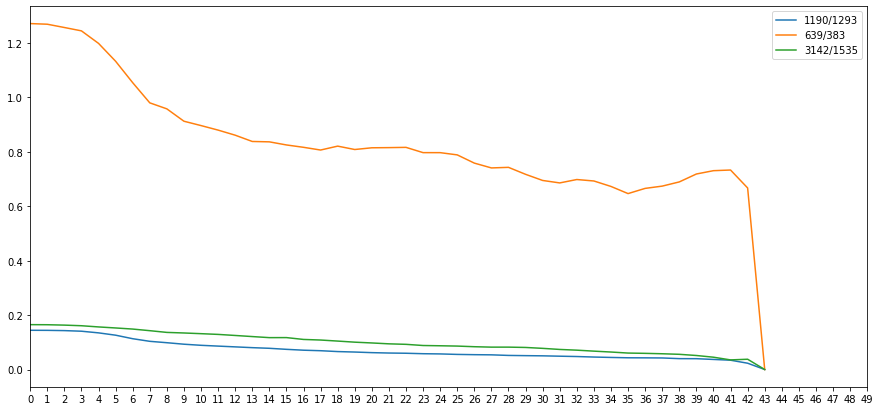

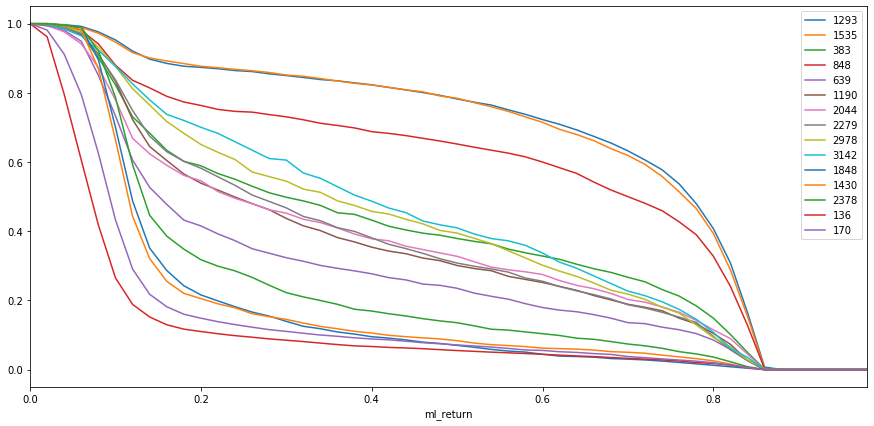

In [27]:
Headers = df_frac.columns.values.tolist()
import plotly.graph_objs as go
from plotly import tools

df_ratio.plot(figsize=(15,7), xticks=range(0, 50)).legend(bbox_to_anchor=(1, 1))
df_frac.plot.line(x='ml_return',figsize=(15,7)).legend(bbox_to_anchor=(1, 1))